# Overview:

This will be the first version of a notebook to analyze and visualize results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import time

from pathlib import Path

import geopandas as gpd

import yaml

$$ $$

# Create a function to run the full test.

- Print out config
- Print out completion rate and counts
- Generate zone map of taxi rejections

In [3]:
def make_zone_count_plot(locationIDs, log_scale=False, count_name="count ", print_nums=True):
    
    counts = (
        locationIDs.dropna().value_counts()
                   .rename_axis('LocationID')
                   .rename('n')
                   .reset_index()
    )
    
    zones = gpd.read_file("data/2023 yellow taxi/taxi_zones/taxi_zones.shp")
    zones = zones.merge(counts, on='LocationID', how="left")
    zones["n"] = zones["n"].fillna(0).astype(int)
    
    if log_scale:
        zones["log_n"] = np.log1p(zones["n"])
    
        fig, ax = plt.subplots(figsize=(10, 10))
        zones.plot(
            column="log_n",
            ax=ax,
            legend=True,
            linewidth=0.2,
            edgecolor="white",
        )
        ax.set_title(f"Log {count_name} by taxi zone")
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

        if print_nums:
            print(counts.sort_values("n", ascending=False).head(15))

    else:
        fig, ax = plt.subplots(figsize=(10, 10))
        zones.plot(
            column="n",
            ax=ax,
            legend=True,
            linewidth=0.2,
            edgecolor="white",
        )
        ax.set_title(f"{count_name} by taxi zone")
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

        if print_nums:
            print(counts.sort_values("n", ascending=False).head(15))




"""

Arguments:
 - test_folder
         string of relative path to test folder
 - log_rejections
         whether to use log scale in rejection plotting
 - unique_rejections
         whether to filter out unique pairs of (id, location) to prevent the same shift from
         continually making rejection requests from the same location

"""
def display_analysis(test_folder, info=None, log_rejections=False, unique_rejections=False, log_unfilled=False, log_below_thres=True, new_threshold=None, unique_thresholds=True):

    test_folder = Path(test_folder)

    print("loading data...", end="")

    primary_rejects_path = test_folder / "primary_rejects.parquet"
    secondary_rejects_path = test_folder / "secondary_rejects.parquet"
    unfilled_path = test_folder / "unfilled_trips.parquet"
    below_thres_path = test_folder / "below_thresholds.parquet"
    test_config_path = test_folder / "test_config.yaml"

    with open(test_config_path,'r') as f:
        config_dict = yaml.safe_load(f)
    
    primary_rejects_df  = pd.read_parquet(primary_rejects_path)
    secondary_rejects_df = pd.read_parquet(secondary_rejects_path)
    unfilled_df = pd.read_parquet(unfilled_path)
    below_df =    pd.read_parquet(below_thres_path)

    print("done")


    # primary rejects plot
    if unique_rejections:

        # filter out rows without unique combos
        print("Primary rejection rows before filtering:", len(primary_rejects_df))        
        unique_rejects_df = (primary_rejects_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Primary rejection rows after filtering:", len(unique_rejects_df))

        make_zone_count_plot(unique_rejects_df['location'], log_scale=log_rejections, count_name="Unique range rejections within same location")
        

    else:
        make_zone_count_plot(primary_rejects_df['location'], log_scale=log_rejections, count_name="Range rejections within same location")


    # secondary rejects plot
    if unique_rejections:

        # filter out rows without unique combos
        print("Secondary rejection rows before filtering:", len(secondary_rejects_df))        
        unique_rejects_df = (secondary_rejects_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Secondary rejection rows after filtering:", len(unique_rejects_df))

        make_zone_count_plot(unique_rejects_df['location'], log_scale=log_rejections, count_name="Unique range rejections to different location")
        

    else:
        make_zone_count_plot(secondary_rejects_df['location'], log_scale=log_rejections, count_name="Range rejections to different location")
    


    print("\n\n\n")


    make_zone_count_plot(unfilled_df['PU_LocationID'], log_scale=log_unfilled, count_name="Unfilled Trip Requests")
    print("\n\n\n")



    # apply new threshold if requested
    if new_threshold:
        print("Below threshold rows before new threshold:", len(below_df))      
        below_df = below_df[below_df['range'] <= new_threshold]
        print("Below threshold rows after new threshold:", len(below_df))

    if unique_thresholds:
        # filter out rows without unique combos
        print("Below threshold rows before unique filtering:", len(below_df))        
        unique_below_df = (below_df.sort_values("request_time").drop_duplicates(subset=["id", "location"], keep="first"))
        print("Below threshold rows after unique filtering:", len(unique_below_df))

        
        make_zone_count_plot(unique_below_df['location'], log_scale=log_below_thres, count_name="Unique below range threshold events")


    else:
        
        make_zone_count_plot(below_df['location'], log_scale=log_below_thres, count_name="Below range threshold events")
    
    print("\n\n\n")
    
    pass

In [4]:
taxi_range: 100
low_range_threshold: 30

connections_threshold: 1


In [5]:
#test = pd.read_parquet('test_sim_baselines_v4/test_1/unfilled_trips.parquet')

In [6]:
#test[test['DO_LocationID'] == 105]

loading data...done


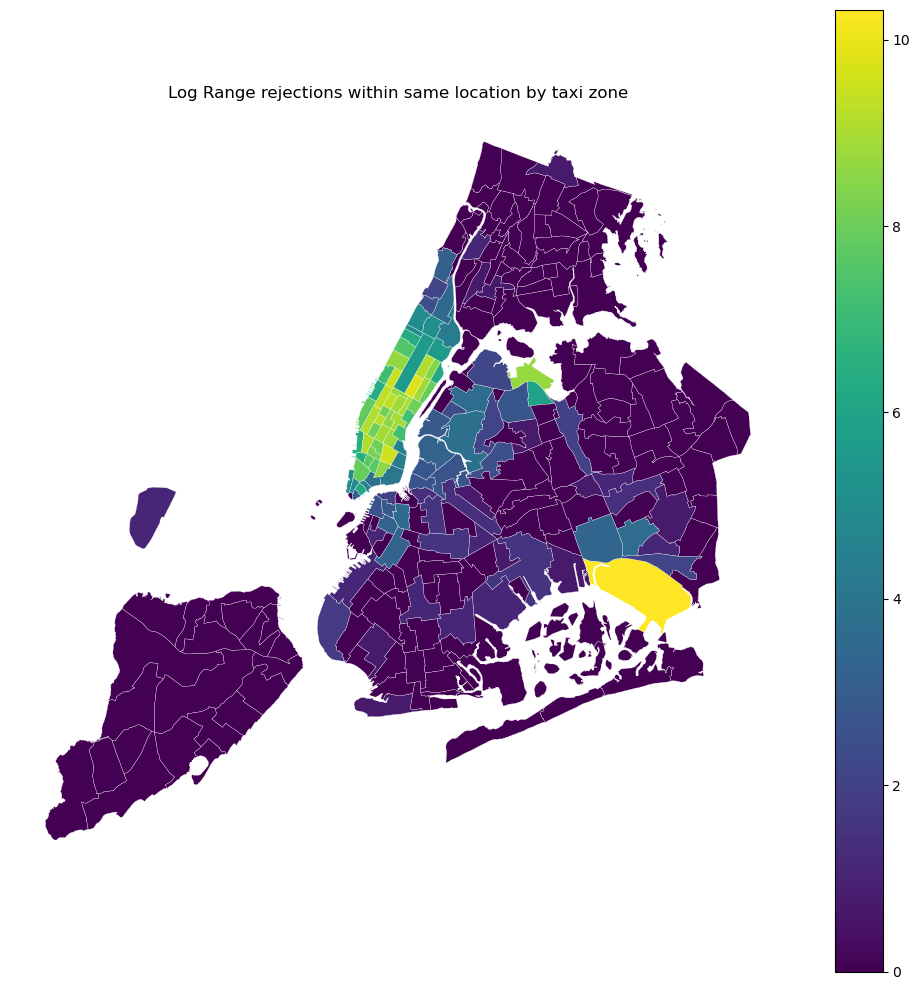

    LocationID      n
0        132.0  30285
1        237.0  17503
2         79.0  14255
3        142.0  13064
4         48.0  11202
5        230.0  10853
6        186.0  10123
7        249.0   9079
8        236.0   9020
9         68.0   8757
10       162.0   8249
11       170.0   7561
12       234.0   7206
13       141.0   7005
14       161.0   6976


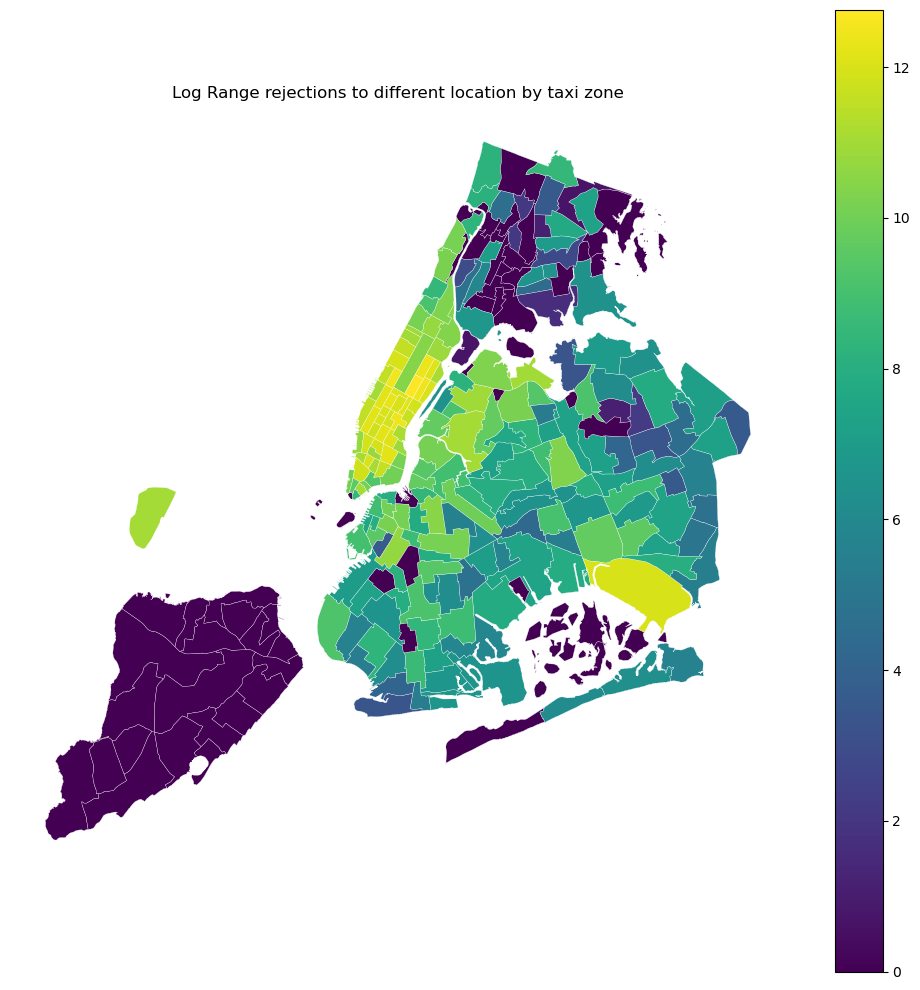

    LocationID       n
0        237.0  347048
1        142.0  264753
2        170.0  254554
3        141.0  254374
4        236.0  242811
5        230.0  214181
6        162.0  196782
7         79.0  196206
8        234.0  195418
9         48.0  193988
10        68.0  193197
11       263.0  185249
12       163.0  174618
13       107.0  173586
14       140.0  167425






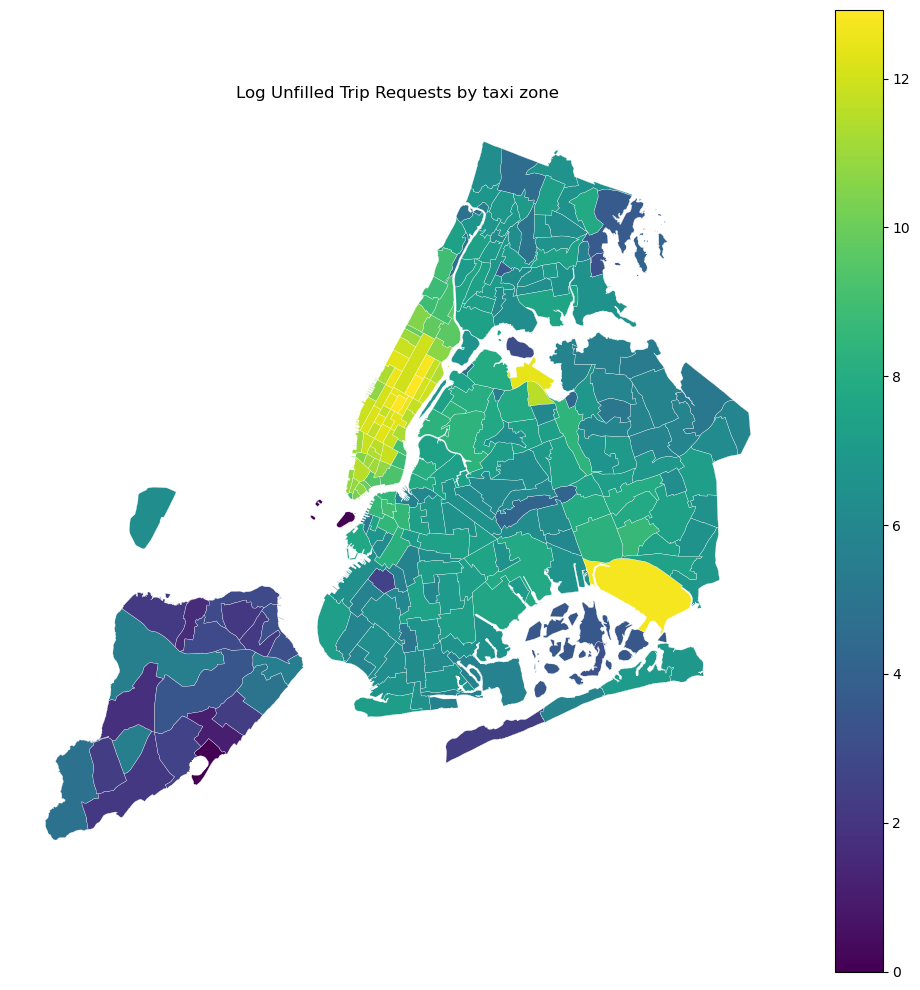

    LocationID       n
0          161  409282
1          237  407560
2          132  348943
3          236  343051
4          162  284068
5          142  282284
6          163  253977
7          230  253048
8          138  247335
9          186  229154
10         239  229025
11         170  228769
12         234  225003
13          68  201744
14         164  181361




Below threshold rows before new threshold: 91623
Below threshold rows after new threshold: 47983
Below threshold rows before unique filtering: 47983
Below threshold rows after unique filtering: 46118


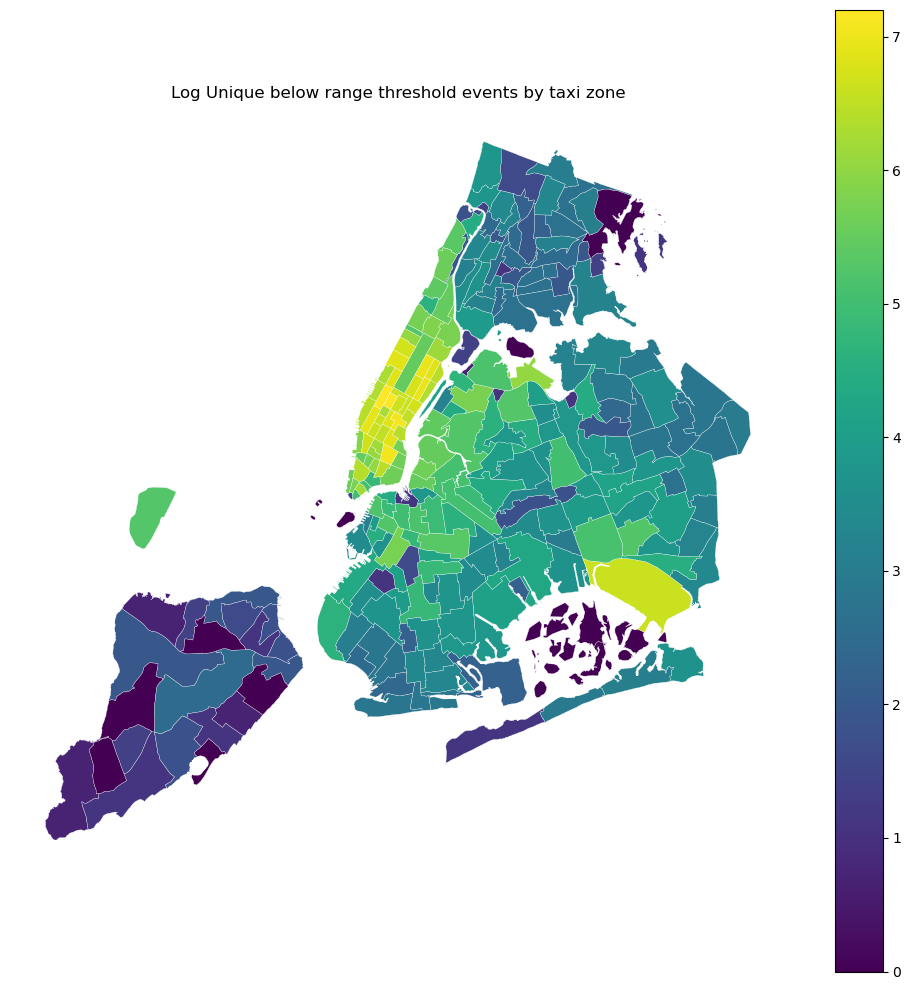

    LocationID     n
0           48  1339
1          230  1269
2          170  1171
3           79  1169
4          141  1049
5          236  1046
6           68  1013
7          265  1009
8          239   967
9          142   954
10         263   952
11         164   946
12         107   945
13         237   863
14         238   829






In [7]:
display_analysis("test_v5/test_0/", unique_rejections=False, log_rejections=True, log_unfilled=True, new_threshold=20)

loading data...done


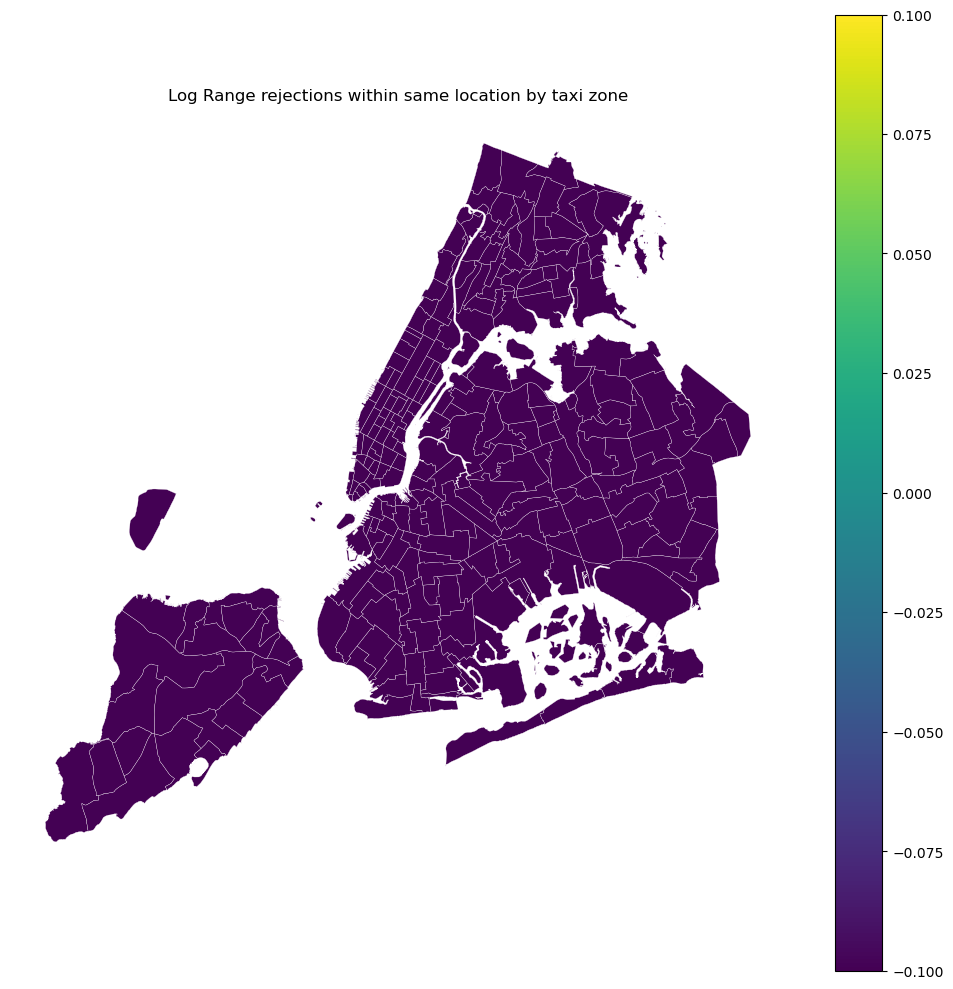

Empty DataFrame
Columns: [LocationID, n]
Index: []


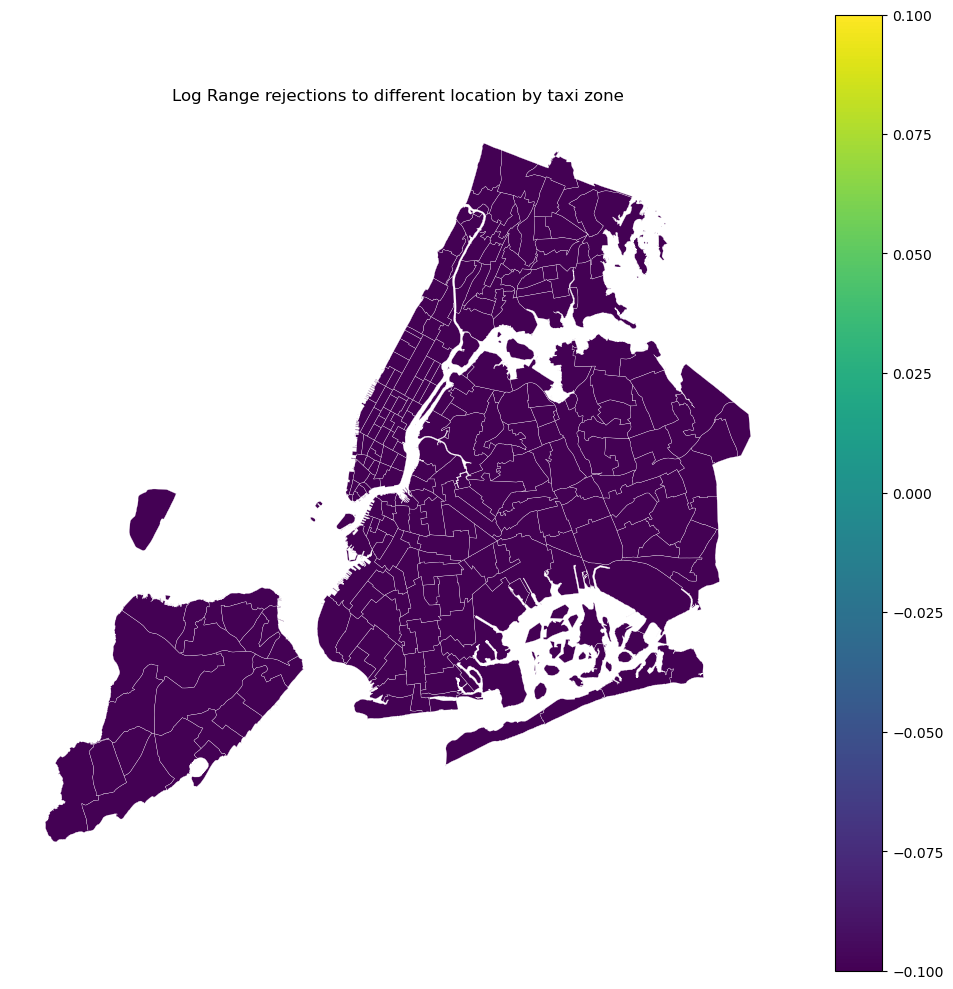

Empty DataFrame
Columns: [LocationID, n]
Index: []






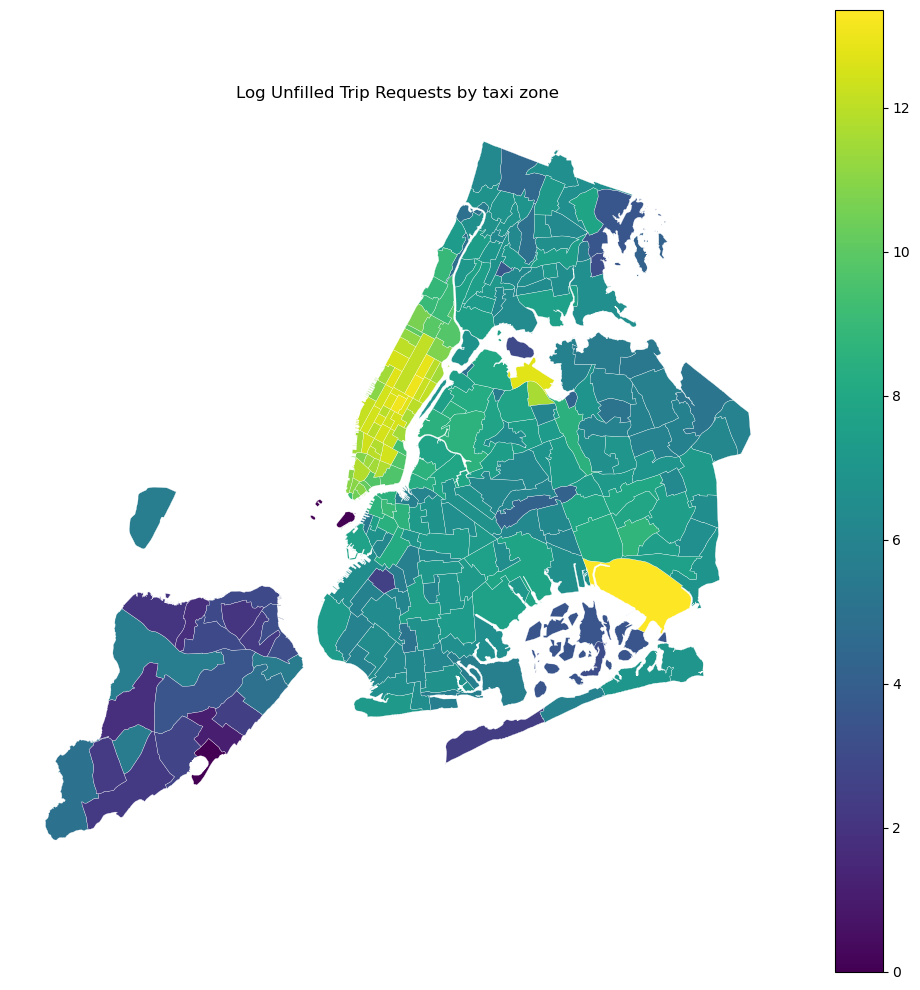

    LocationID       n
0          132  633520
1          161  466614
2          237  452759
3          236  378114
4          138  350332
5          142  329285
6          162  326172
7          230  316421
8          163  296410
9          186  288438
10         234  273336
11         170  268461
12         239  262134
13          68  257883
14          79  255471




Below threshold rows before new threshold: 6502065
Below threshold rows after new threshold: 4622559
Below threshold rows before unique filtering: 4622559
Below threshold rows after unique filtering: 4284075


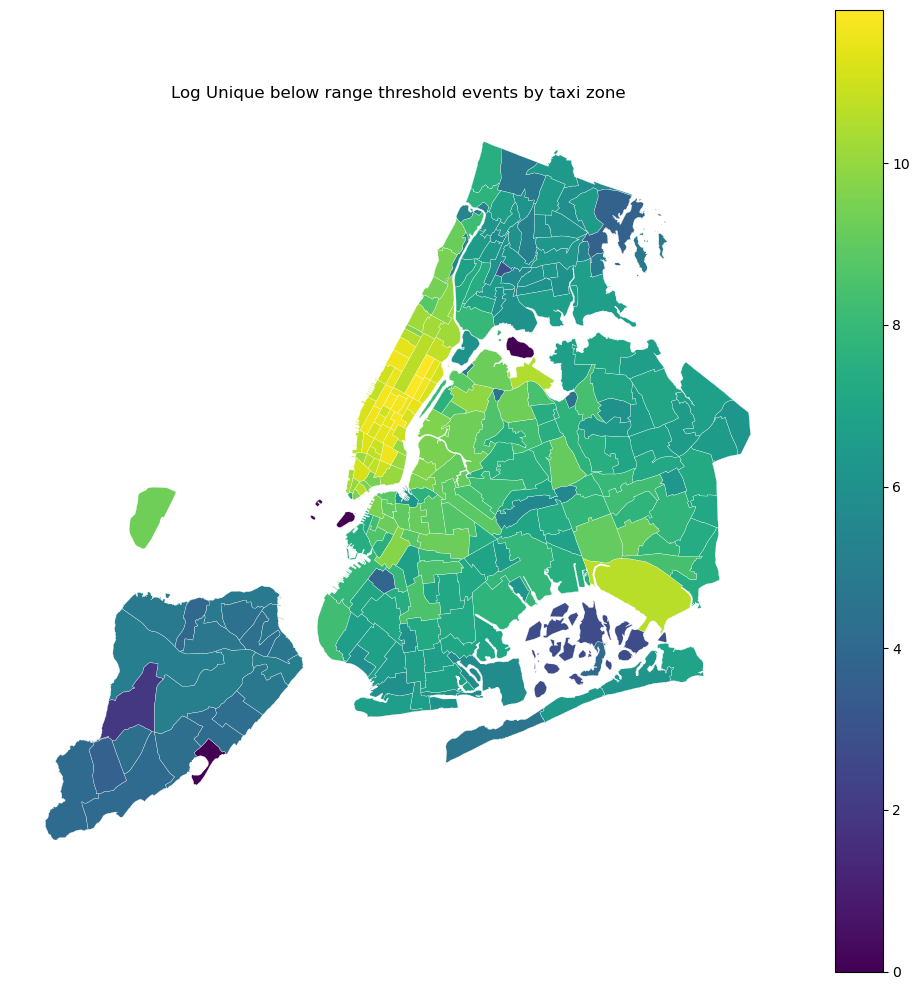

    LocationID       n
0          236  146768
1          237  136272
2          170  126919
3          230  124054
4          161  119370
5           48  119066
6          141  113121
7           79  110878
8          239  107291
9           68  106651
10         142  103055
11         162  101368
12         164   95775
13         163   94127
14         107   93958






In [8]:
display_analysis("test_v5/test_4/", unique_rejections=False, log_rejections=True, log_unfilled=True, new_threshold=20)

In [11]:
test_folder = Path("test_v5/test_4/")

primary_rejects_path = test_folder / "primary_rejects.parquet"
secondary_rejects_path = test_folder / "secondary_rejects.parquet"
unfilled_path = test_folder / "unfilled_trips.parquet"
below_thres_path = test_folder / "below_thresholds.parquet"

p_rejects_df =  pd.read_parquet(primary_rejects_path)
s_rejects_df =  pd.read_parquet(secondary_rejects_path)
unfilled_df = pd.read_parquet(unfilled_path)
below_df =    pd.read_parquet(below_thres_path)

In [15]:
below_df

,request_time,id,location,range,shift_end,just_traveled,just_traveled_trip_distance,just_traveled_in_between_distance
0,2023-01-01 03:02:51,1225.0,9,28.748040,2023-01-01 04:49:19,27.527324,11.80,15.727324
1,2023-01-01 04:31:22,119.0,68,10.978492,2023-01-01 03:49:03,45.635459,35.18,10.455459
2,2023-01-01 04:29:00,1290.0,257,15.697883,2023-01-01 04:29:00,35.766697,23.10,12.666697
3,2023-01-01 04:19:50,666.0,245,22.859411,2023-01-01 05:24:24,20.725408,19.89,0.835408
4,2023-01-01 03:54:08,837.0,224,29.511641,2023-01-01 05:05:43,9.397262,1.91,7.487262
...,...,...,...,...,...,...,...,...
6502060,2023-12-31 23:59:58,1837913.0,170,0.027565,2024-01-01 01:39:00,0.301961,0.08,0.221961
6502061,2024-01-01 00:11:09,1837794.0,234,8.611849,2024-01-01 03:54:05,0.532377,0.08,0.452377
6502062,2023-12-31 23:59:30,1838092.0,231,0.007603,2024-01-01 02:48:00,0.762012,0.39,0.372012
6502063,2024-01-01 00:12:11,1838512.0,162,3.243476,2024-01-01 00:20:19,0.915859,0.29,0.625859


In [11]:
df = rejects_df

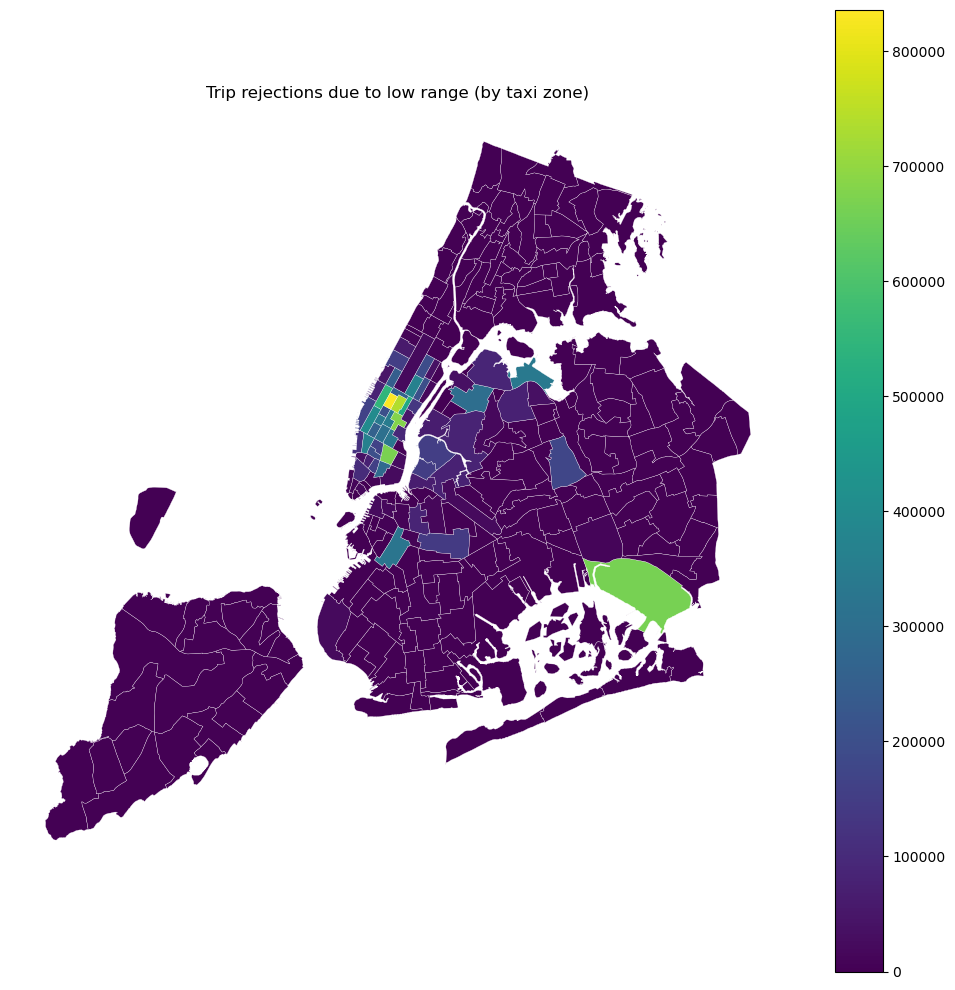

     LocationID  n_reject
218         230    835818
153         161    738254
162         170    680483
77           79    667094
125         132    664397
46           48    545408
154         162    503999
66           68    400312
237         249    364661
225         237    364043
156         164    348069
176         186    338405
131         138    337586
102         107    326597
172         181    324405


In [12]:


# df = your rejection dataframe (the one you printed)
# df columns include: location (taxi’s current zone when it rejected)
df["location"] = pd.to_numeric(df["location"], errors="coerce")

# 1) counts by taxi zone
counts = (
    df.dropna(subset=["location"])
      .assign(LocationID=lambda d: d["location"].astype(int))
      .groupby("LocationID")
      .size()
      .rename("n_reject")
      .reset_index()
)

# 2) read zones + join counts
zones = gpd.read_file("data/2023 yellow taxi/taxi_zones/taxi_zones.shp")  # adjust path if needed
zones = zones.merge(counts, on="LocationID", how="left")
zones["n_reject"] = zones["n_reject"].fillna(0).astype(int)

# (optional) log scale if counts are very skewed
#zones["log_reject"] = np.log1p(zones["n_reject"])

# 3) plot
fig, ax = plt.subplots(figsize=(10, 10))
zones.plot(
    column="n_reject",           # use "n_reject" if you don’t want log scale
    ax=ax,
    legend=True,
    linewidth=0.2,
    edgecolor="white",
)
ax.set_title("Trip rejections due to low range (by taxi zone)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# quick sanity check: top hotspots
print(counts.sort_values("n_reject", ascending=False).head(15))

In [26]:
test = rejects_df['location'].dropna().value_counts()

In [34]:
test = (rejects_df['location'].dropna().value_counts())

In [35]:
test

location
230    835818
161    738254
170    680483
79     667094
132    664397
        ...  
253         1
111         1
105         1
115         1
187         1
Name: count, Length: 252, dtype: int64

In [39]:
a = pd.to_numeric(rejects_df['location'], errors="coerce").dropna().astype(int)

In [42]:
test = (a.value_counts()
         .rename_axis('abc')
         .rename('n')
         .reset_index())

In [43]:
test

,abc,n
0,230,835818
1,161,738254
2,170,680483
3,79,667094
4,132,664397
...,...,...
247,253,1
248,111,1
249,105,1
250,115,1


# Evaluate difference in distance distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import wasserstein_distance

In [4]:
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y


def eval_sim_vs_gt_distances(sim_num, max_dist=400, bins=200):
    # load true distances
    gt_shift_info = pd.read_parquet('shifts_distance_info.parquet')
    gt_distances = gt_shift_info['total_dist'].to_numpy()

    # load distances from a gt simulation
    sim_distances = np.load(f"gt_test_v4/test_{sim_num}/total_distances_array.npy")

    # cut to reasonable max dist
    gt = gt_distances[gt_distances < max_dist].copy()
    sim = sim_distances[sim_distances < max_dist].copy()


    # setup for three plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    
    # create histogram comparison plot
    ax = axes[0]
    
    ax.hist(gt,  bins=bins, density=True, alpha=0.35, label="Ground truth")
    ax.hist(sim, bins=bins, density=True, alpha=0.35, label="Simulation")
    ax.set_xlabel("Shift total distance")
    ax.set_ylabel("Density")
    ax.legend(loc='upper right')


    # create ecdf comparison plot
    ax = axes[1]
    
    xg, yg = ecdf(gt)
    xs, ys = ecdf(sim)
    ax.step(xg, yg, where="post", label="Ground truth")
    ax.step(xs, ys, where="post", label="Simulation")
    ax.set_xlabel("Shift total distance")
    ax.set_ylabel("ECDF")
    ax.legend(loc="upper left")

    # create QQ plot
    ax = axes[2]

    qgrid = np.linspace(0.01, 0.99, 99)
    ax.plot(np.quantile(gt, qgrid), np.quantile(sim, qgrid), marker=".", linestyle="none")
    m = max(gt.max(), sim.max())
    ax.plot([0, m], [0, m])
    ax.set_xlabel("Ground truth quantiles")
    ax.set_ylabel("Simulation quantiles")

    #plt.savefig("gt_vs_sim_example.jpg", dpi=300, bbox_inches="tight")
    
    plt.show()

    # print stats
    # --- KS test/statistic ---
    ks = stats.ks_2samp(gt, sim, alternative="two-sided", mode="auto")
    print("KS statistic:", ks.statistic, "p-value:", ks.pvalue)
    
    # --- Wasserstein distance ---
    wd = wasserstein_distance(gt, sim)
    print("Wasserstein distance:", wd)
    
    # --- Quantile comparison ---
    qs = [0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 0.99]
    gt_q = np.quantile(gt, qs)
    sim_q = np.quantile(sim, qs)
    rel_err = (sim_q - gt_q) / gt_q
    for q, g, s, e in zip(qs, gt_q, sim_q, rel_err):
        print(f"Q{int(q*100):02d}: gt={g:.2f}, sim={s:.2f}, rel_err={e:+.1%}")
        
    

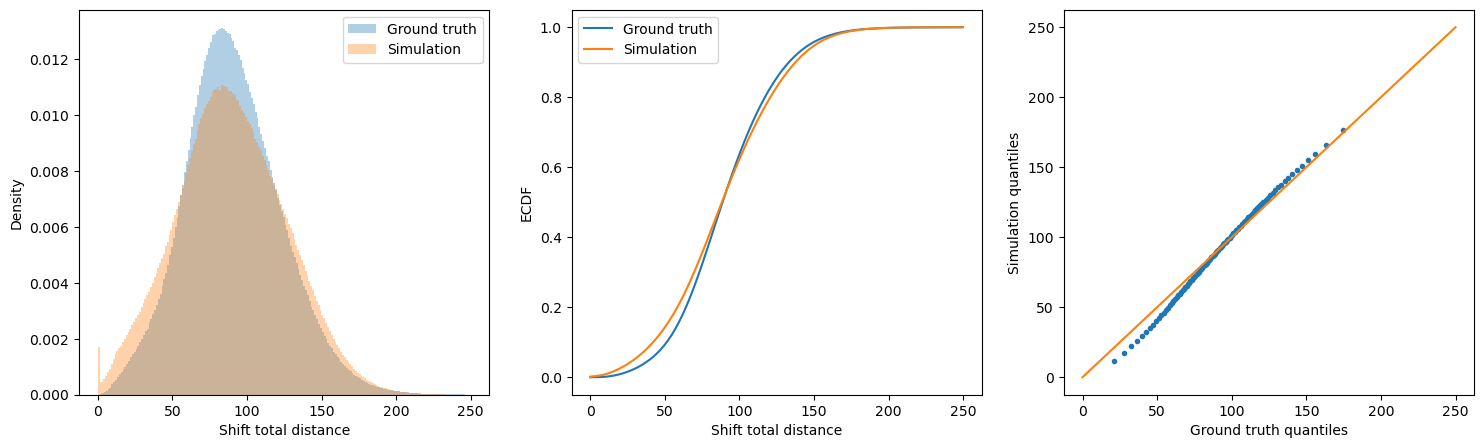

KS statistic: 0.051444261290957444 p-value: 0.0
Wasserstein distance: 3.8630473563528023
Q25: gt=68.93, sim=64.40, rel_err=-6.6%
Q40: gt=81.05, sim=79.19, rel_err=-2.3%
Q50: gt=88.72, sim=88.30, rel_err=-0.5%
Q60: gt=96.81, sim=97.77, rel_err=+1.0%
Q75: gt=111.17, sim=114.19, rel_err=+2.7%
Q90: gt=133.22, sim=137.61, rel_err=+3.3%
Q99: gt=174.28, sim=176.34, rel_err=+1.2%


In [5]:
eval_sim_vs_gt_distances(sim_num=0, max_dist=250)

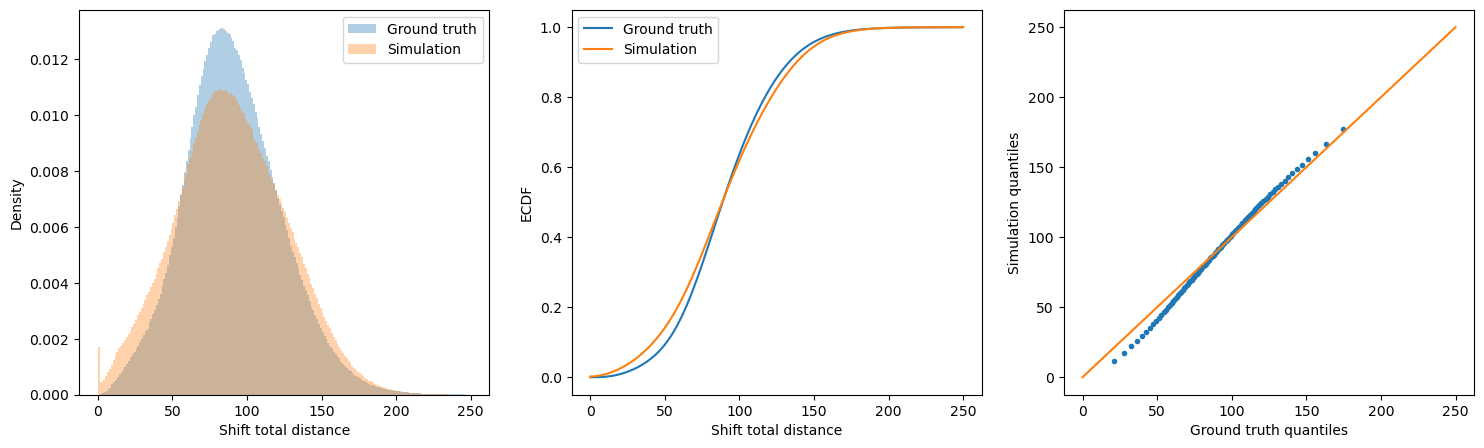

KS statistic: 0.05049468552183592 p-value: 0.0
Wasserstein distance: 4.01708710912442
Q40: gt=81.05, sim=79.32, rel_err=-2.1%
Q50: gt=88.72, sim=88.51, rel_err=-0.2%
Q75: gt=111.17, sim=114.70, rel_err=+3.2%
Q90: gt=133.22, sim=138.29, rel_err=+3.8%
Q95: gt=146.88, sim=151.76, rel_err=+3.3%
Q99: gt=174.28, sim=177.15, rel_err=+1.6%


In [16]:
eval_sim_vs_gt_distances(sim_num=1, max_dist=250)

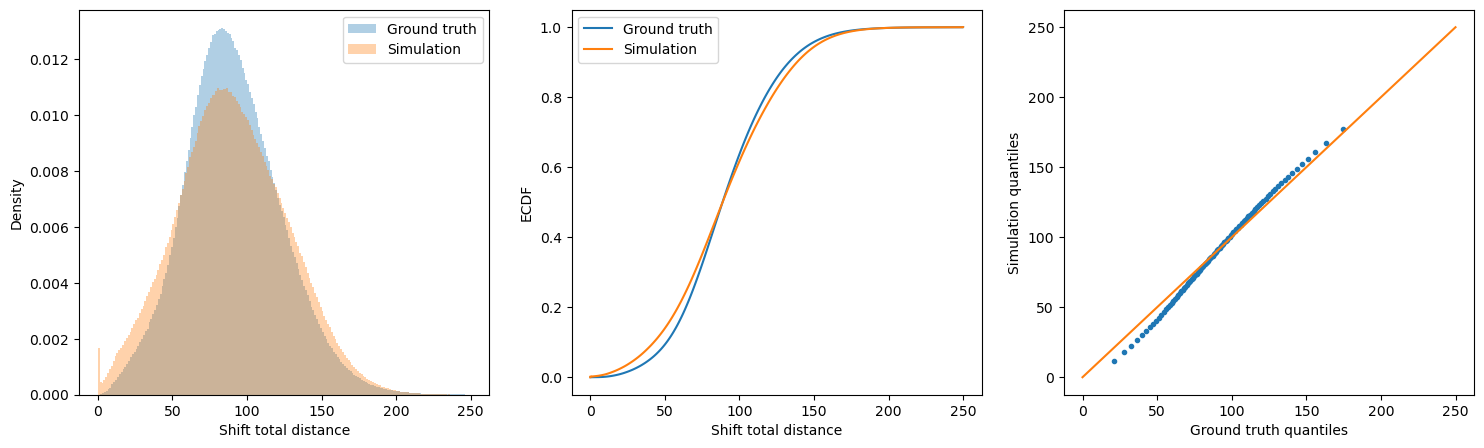

KS statistic: 0.04840025007151347 p-value: 0.0
Wasserstein distance: 4.013365298053035
Q40: gt=81.05, sim=79.61, rel_err=-1.8%
Q50: gt=88.72, sim=88.77, rel_err=+0.0%
Q75: gt=111.17, sim=114.95, rel_err=+3.4%
Q90: gt=133.22, sim=138.61, rel_err=+4.0%
Q95: gt=146.88, sim=152.12, rel_err=+3.6%
Q99: gt=174.28, sim=177.50, rel_err=+1.9%


In [18]:
eval_sim_vs_gt_distances(sim_num=2, max_dist=250)

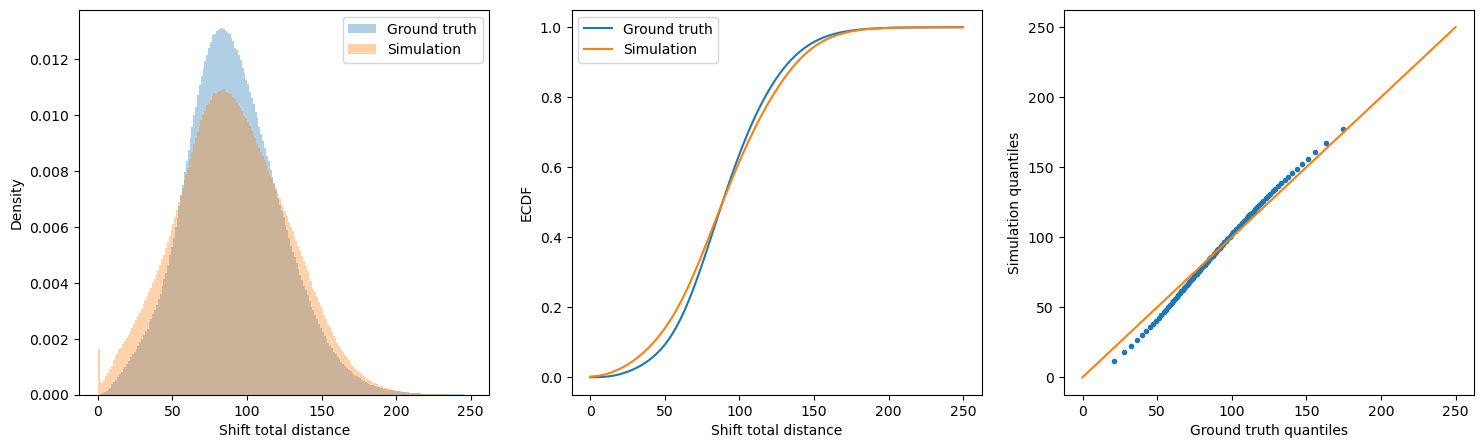

KS statistic: 0.04864164674890897 p-value: 0.0
Wasserstein distance: 4.073343915964795
Q40: gt=81.05, sim=79.58, rel_err=-1.8%
Q50: gt=88.72, sim=88.79, rel_err=+0.1%
Q75: gt=111.17, sim=115.08, rel_err=+3.5%
Q90: gt=133.22, sim=138.70, rel_err=+4.1%
Q95: gt=146.88, sim=152.15, rel_err=+3.6%
Q99: gt=174.28, sim=177.43, rel_err=+1.8%


In [19]:
eval_sim_vs_gt_distances(sim_num=3, max_dist=250)

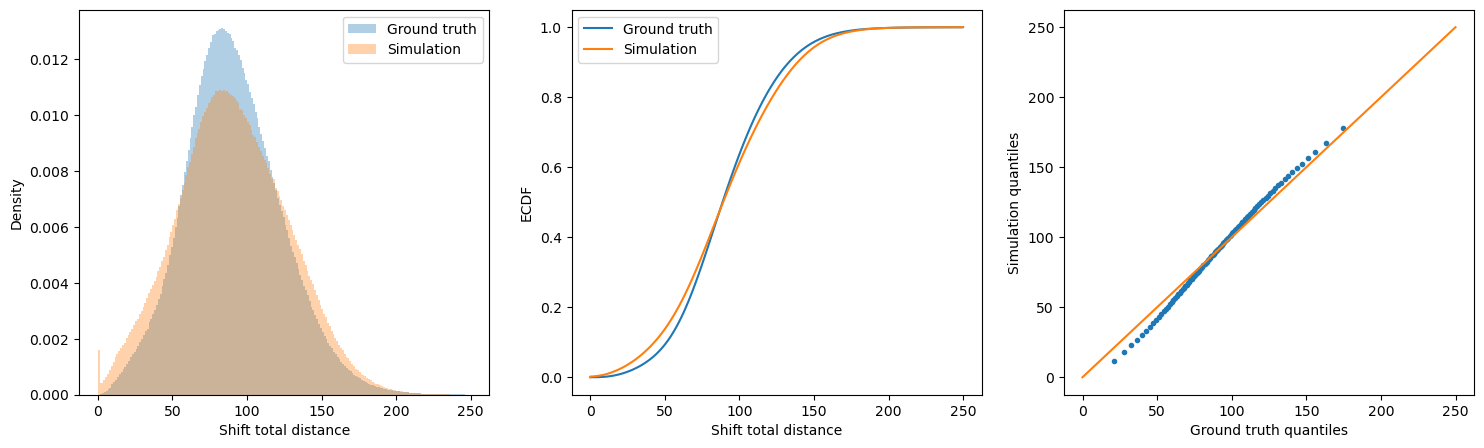

KS statistic: 0.04616432470561013 p-value: 0.0
Wasserstein distance: 4.087469795570182
Q40: gt=81.05, sim=79.89, rel_err=-1.4%
Q50: gt=88.72, sim=89.11, rel_err=+0.4%
Q75: gt=111.17, sim=115.41, rel_err=+3.8%
Q90: gt=133.22, sim=139.05, rel_err=+4.4%
Q95: gt=146.88, sim=152.51, rel_err=+3.8%
Q99: gt=174.28, sim=177.94, rel_err=+2.1%


In [20]:
eval_sim_vs_gt_distances(sim_num=4, max_dist=250)

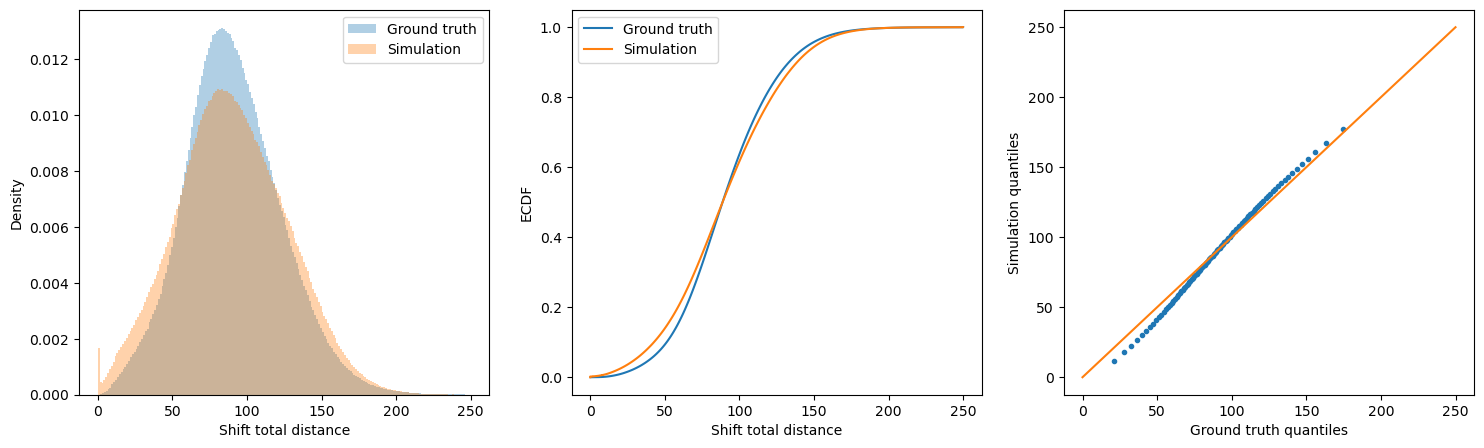

KS statistic: 0.04849289966829065 p-value: 0.0
Wasserstein distance: 4.0408232489964355
Q40: gt=81.05, sim=79.54, rel_err=-1.9%
Q50: gt=88.72, sim=88.73, rel_err=+0.0%
Q75: gt=111.17, sim=115.00, rel_err=+3.4%
Q90: gt=133.22, sim=138.66, rel_err=+4.1%
Q95: gt=146.88, sim=152.14, rel_err=+3.6%
Q99: gt=174.28, sim=177.42, rel_err=+1.8%


In [21]:
eval_sim_vs_gt_distances(sim_num=5, max_dist=250)

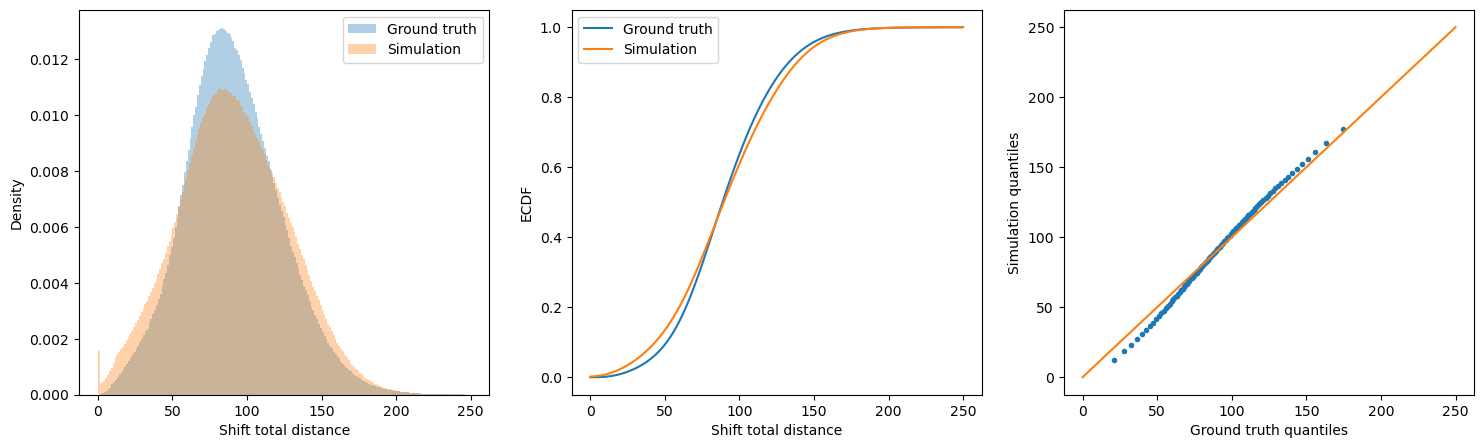

KS statistic: 0.04233025131133425 p-value: 0.0
Wasserstein distance: 3.9158593693605415
Q40: gt=81.05, sim=80.36, rel_err=-0.9%
Q50: gt=88.72, sim=89.53, rel_err=+0.9%
Q75: gt=111.17, sim=115.57, rel_err=+4.0%
Q90: gt=133.22, sim=138.78, rel_err=+4.2%
Q95: gt=146.88, sim=152.11, rel_err=+3.6%
Q99: gt=174.28, sim=177.26, rel_err=+1.7%


In [22]:
eval_sim_vs_gt_distances(sim_num=6, max_dist=250)

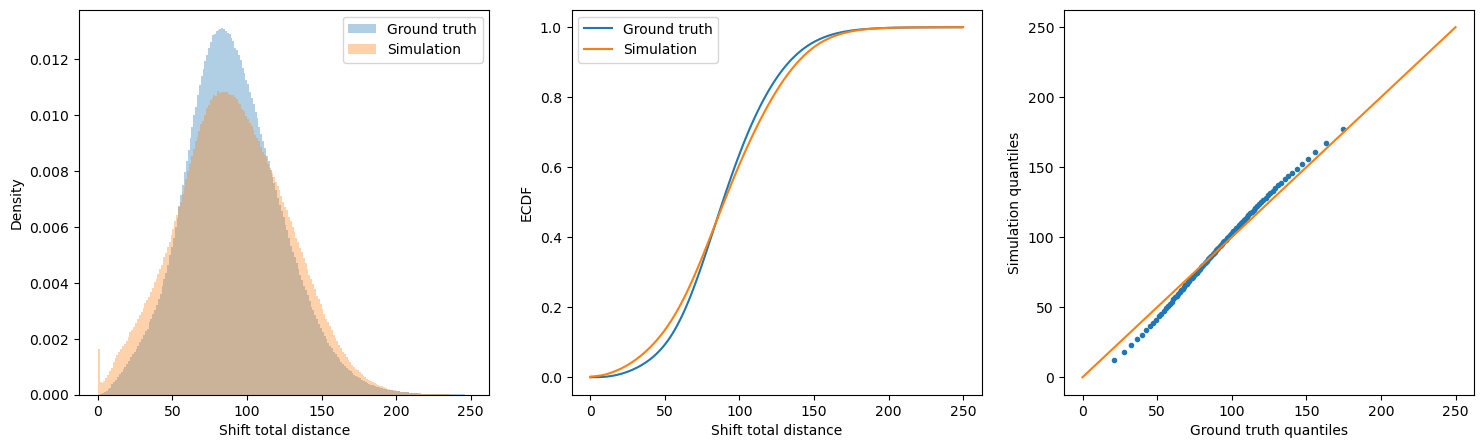

KS statistic: 0.042756669182041074 p-value: 0.0
Wasserstein distance: 4.044823338290021
Q40: gt=81.05, sim=80.42, rel_err=-0.8%
Q50: gt=88.72, sim=89.68, rel_err=+1.1%
Q75: gt=111.17, sim=115.80, rel_err=+4.2%
Q90: gt=133.22, sim=139.03, rel_err=+4.4%
Q95: gt=146.88, sim=152.36, rel_err=+3.7%
Q99: gt=174.28, sim=177.47, rel_err=+1.8%


In [23]:
eval_sim_vs_gt_distances(sim_num=7, max_dist=250)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

### Batch the large data frame into multiple for multiprocessing

In [6]:
# load full trip dataframe
full_2013_df = pd.read_parquet('data/FOIL data/filtered/FOIL_filtered_all.parquet')
full_2013_df.drop(columns=['medallion', 'rate_code'], inplace=True)

In [3]:
# load the shifts info dataframe
shifts_df = pd.read_parquet('data/distilled taxi data/shift_info_df.parquet')

#shifts_df

In [4]:
batch_size = 1500

In [5]:
# set licenses by which ones we have shifts for
licenses = shifts_df["hack_license"].unique()

batches = [
    (i, licenses[i*batch_size:(i+1)*batch_size])
    for i in range(int(np.ceil(len(licenses) / batch_size)))
]

print(f"There are {len(batches)} batches.")

There are 27 batches.


In [6]:
total_rows_written = 0

out_folder = "data/2013_dist_batches/"

# empty the out folder
import shutil
import os

if os.path.isdir(out_folder):
    shutil.rmtree(out_folder)

os.mkdir(out_folder)

for batch in tqdm(batches):
    
    idx, licenses = batch

    # filter out batch df from full df
    batch_df = full_2013_df[full_2013_df["hack_license"].isin(licenses)].copy()

    # create and batch save folder
    os.mkdir(out_folder + f"/batch_{idx}")

    # write parquet file for batch
    out_path = out_folder + f"/batch_{idx}/batch_df.parquet"
    batch_df.to_parquet(out_path, index=False)

    total_rows_written += len(batch_df)

print("total_rows_written:", total_rows_written)

100%|██████████████████████████████████████████████████████████████████████████████| 27/27 [01:57<00:00,  4.34s/it]

total_rows_written: 167962744


In [7]:
import gc

del full_2013_df
del batch_df

gc.collect()

0

$$ $$

$$ $$

## Use multiprocessing helper to process batches

In [8]:
import multiprocessing
from multiprocessing import Pool
import utils.shift_dist_2013_multiprocessing as batch_processing_helper

In [9]:
batch_nums = list(range(len(batches)))
print("Number of batches:", len(batch_nums))

#sys.exit()
if __name__ == '__main__':
    pool = Pool(processes=15)
    batch_results = pool.map(batch_processing_helper.process_saved_batch, batch_nums)

Number of batches: 27


In [10]:
total = 0

for b in batch_results:
    total += b[1]

print(total)

7265143


$$ $$

### Concatenate all batch between trip results to one dataframe

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# get all batch folder names
base_path = Path("data/2013_dist_batches")

batch_folders = [p.name for p in base_path.iterdir() if p.is_dir()]

In [3]:
all_dfs = []

for batch_folder in batch_folders:    
    file_path = f"data/2013_dist_batches/{batch_folder}/batch_result.parquet"
    
    df = pd.read_parquet(file_path)
    
    all_dfs.append(df)

del df

# concatenate
full_df = pd.concat(all_dfs, ignore_index=True)
print(f"Full concatenated shape: {full_df.shape}")

del all_dfs

Full concatenated shape: (7265143, 9)


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7265143 entries, 0 to 7265142
Data columns (total 9 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hack_license          int64         
 1   shift_start           datetime64[us]
 2   shift_end             datetime64[us]
 3   shift_duration_min    float64       
 4   shift_start_location  float64       
 5   hours                 float64       
 6   tot_trip              float64       
 7   tot_ib                float64       
 8   tot_dist              float64       
dtypes: datetime64[us](2), float64(6), int64(1)
memory usage: 498.9 MB


In [5]:
full_df

,hack_license,shift_start,shift_end,shift_duration_min,shift_start_location,hours,tot_trip,tot_ib,tot_dist
0,2013000001,2013-01-04 16:40:00,2013-01-05 04:19:00,699.0,233.0,11.650000,66.41,46.794614,113.204614
1,2013000001,2013-01-07 11:51:00,2013-01-08 00:47:00,776.0,162.0,12.933333,68.53,38.444284,106.974284
2,2013000001,2013-01-11 17:29:00,2013-01-12 04:37:00,668.0,164.0,11.133333,82.46,63.101640,145.561640
3,2013000001,2013-01-12 18:21:00,2013-01-13 05:06:00,645.0,234.0,10.750000,91.16,41.586907,132.746907
4,2013000001,2013-01-14 13:50:00,2013-01-15 00:28:00,638.0,158.0,10.633333,84.15,49.708752,133.858752
...,...,...,...,...,...,...,...,...,...
7265138,2013015034,2013-09-17 08:35:00,2013-09-17 15:59:00,444.0,140.0,7.400000,0.00,0.000000,0.000000
7265139,2013015034,2013-09-18 08:16:00,2013-09-18 15:52:00,456.0,140.0,7.600000,0.00,0.000000,0.000000
7265140,2013015034,2013-09-19 07:36:00,2013-09-19 13:56:00,380.0,260.0,6.333333,0.00,0.000000,0.000000
7265141,2013015034,2013-09-20 08:32:00,2013-09-20 15:38:00,426.0,141.0,7.100000,0.00,0.000000,0.000000


In [23]:
dists = full_df['tot_dist'].to_numpy()


In [24]:
np.sum(dists > 200)

np.int64(712)

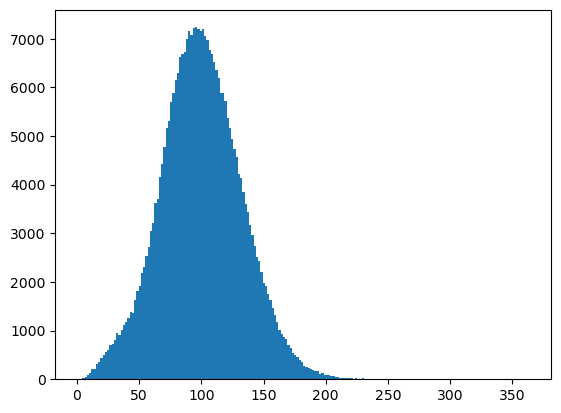

In [26]:

plt.hist(dists[dists > 0], bins=200)

plt.show()

In [8]:
license_df = full_2013_df[full_2013_df['hack_license'] == 2013015034]

In [9]:
license_df

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
159704,2013015034,2013-01-01 08:57:00,2013-01-01 09:26:00,12.99,-73.945541,40.777786,-73.944611,40.654526
167996,2013015034,2013-01-01 10:05:00,2013-01-01 10:20:00,3.50,-73.940414,40.789799,-73.961761,40.800816
170419,2013015034,2013-01-01 10:21:00,2013-01-01 10:26:00,1.32,-73.940414,40.789799,-73.970909,40.798370
173708,2013015034,2013-01-01 10:40:00,2013-01-01 10:57:00,4.02,-73.947578,40.783718,-73.984756,40.748291
177697,2013015034,2013-01-01 11:00:00,2013-01-01 11:18:00,5.56,-73.986320,40.747128,-74.007774,40.703117
...,...,...,...,...,...,...,...,...
121898250,2013015034,2013-09-22 15:14:00,2013-09-22 15:24:00,1.52,-73.959129,40.774593,-73.976433,40.764256
121903342,2013015034,2013-09-22 15:28:00,2013-09-22 15:31:00,0.53,-73.976265,40.766041,-73.982376,40.762192
121905644,2013015034,2013-09-22 15:34:00,2013-09-22 15:39:00,0.69,-73.985207,40.763153,-73.981857,40.771519
121911195,2013015034,2013-09-22 15:49:00,2013-09-22 15:58:00,0.91,-73.963547,40.765282,-73.972099,40.762096


In [11]:
shift_start = pd.Timestamp('2013-09-21 08:37:00')
shift_end   = pd.Timestamp('2013-09-21 15:54:00')

license_df[(license_df['pickup_datetime'] >= shift_start) & (license_df['dropoff_datetime'] <= shift_end)] 

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
121238062,2013015034,2013-09-21 08:37:00,2013-09-21 08:50:00,2.45,-73.959335,40.763348,-73.951599,40.790932
121242266,2013015034,2013-09-21 08:54:00,2013-09-21 09:17:00,7.61,-73.957718,40.785248,-74.014252,40.711651
121268163,2013015034,2013-09-21 10:21:00,2013-09-21 10:33:00,1.49,-73.953018,40.768085,-73.969376,40.756004
121275021,2013015034,2013-09-21 10:41:00,2013-09-21 10:48:00,1.40,-73.964363,40.773354,-73.972374,40.786667
121278524,2013015034,2013-09-21 10:50:00,2013-09-21 11:08:00,2.71,-73.975189,40.787670,-73.963692,40.774246
121286301,2013015034,2013-09-21 11:11:00,2013-09-21 11:17:00,0.74,-73.961319,40.777489,-73.954422,40.786926
121291631,2013015034,2013-09-21 11:25:00,2013-09-21 11:48:00,2.56,-73.954041,40.784687,-73.977806,40.752682
121302527,2013015034,2013-09-21 11:52:00,2013-09-21 12:12:00,3.05,-73.974663,40.759281,-73.946304,40.783714
121312014,2013015034,2013-09-21 12:15:00,2013-09-21 12:24:00,1.51,-73.949875,40.780300,-73.963837,40.761326
121316049,2013015034,2013-09-21 12:25:00,2013-09-21 12:33:00,1.89,-73.964836,40.760048,-73.978943,40.736900


In [31]:
full_2013_df = pd.read_parquet('data/FOIL data/filtered/FOIL_filtered_all.parquet')

full_2013_df.drop(columns=['medallion', 'rate_code'], inplace=True)

In [32]:
full_2013_df

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013000001,2013-01-01 00:00:00,2013-01-01 00:28:00,3.94,-73.990784,40.760880,-73.954185,40.778847
1,2013000002,2013-01-01 00:00:00,2013-01-01 00:06:00,0.98,-73.978325,40.778091,-73.981834,40.768639
2,2013000003,2013-01-01 00:00:00,2013-01-01 00:10:00,2.77,-73.989616,40.729988,-74.013779,40.705036
3,2013000004,2013-01-01 00:00:00,2013-01-01 00:08:00,1.68,-73.981575,40.767632,-73.977737,40.757927
4,2013000005,2013-01-01 00:00:00,2013-01-01 00:16:00,4.05,-74.000526,40.737343,-73.977226,40.783607
...,...,...,...,...,...,...,...,...
168038824,2013005933,2013-12-31 23:58:04,2013-12-31 23:58:49,0.40,-73.980141,40.780449,-73.979752,40.781086
168038825,2013041469,2013-12-31 23:58:11,2013-12-31 23:59:17,0.60,-73.953415,40.771271,-73.948189,40.778557
168038826,2013006793,2013-12-31 23:58:28,2013-12-31 23:59:37,0.50,-73.959702,40.779617,-73.954620,40.784050
168038827,2013000913,2013-12-31 23:58:34,2013-12-31 23:59:32,0.30,-73.982010,40.757233,-73.979866,40.760914


In [33]:
shifts_df = pd.read_parquet('data/distilled taxi data/shift_info_df.parquet')

In [37]:
shifts_df

,hack_license,shift_start,shift_end,shift_duration_min,shift_start_location,hours
0,2013000001,2013-01-04 16:40:00,2013-01-05 04:19:00,699.0,233.0,11.650000
1,2013000001,2013-01-07 11:51:00,2013-01-08 00:47:00,776.0,162.0,12.933333
2,2013000001,2013-01-11 17:29:00,2013-01-12 04:37:00,668.0,164.0,11.133333
3,2013000001,2013-01-12 18:21:00,2013-01-13 05:06:00,645.0,234.0,10.750000
4,2013000001,2013-01-14 13:50:00,2013-01-15 00:28:00,638.0,158.0,10.633333
...,...,...,...,...,...,...
7585943,2013043143,2013-12-29 07:15:00,2013-12-29 17:08:00,593.0,141.0,9.883333
7585944,2013043143,2013-12-30 06:40:00,2013-12-30 16:23:00,583.0,113.0,9.716667
7585945,2013043144,2013-12-29 06:36:00,2013-12-29 16:45:00,609.0,141.0,10.150000
7585946,2013043144,2013-12-30 06:13:00,2013-12-30 16:43:00,630.0,263.0,10.500000


In [38]:
curr_shift = shifts_df.iloc[0]

In [39]:
curr_shift

hack_license                     2013000001
shift_start             2013-01-04 16:40:00
shift_end               2013-01-05 04:19:00
shift_duration_min                    699.0
shift_start_location                  233.0
hours                                 11.65
Name: 0, dtype: object

In [40]:
license_df = full_2013_df[full_2013_df['hack_license'] == curr_shift['hack_license']]

In [41]:
license_df

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013000001,2013-01-01 00:00:00,2013-01-01 00:28:00,3.94,-73.990784,40.760880,-73.954185,40.778847
22786,2013000001,2013-01-01 00:50:00,2013-01-01 01:08:00,2.23,-73.983459,40.752281,-73.992424,40.730438
32561,2013000001,2013-01-01 01:08:00,2013-01-01 01:19:00,2.71,-73.983459,40.752281,-73.967735,40.751564
39976,2013000001,2013-01-01 01:22:00,2013-01-01 01:28:00,1.76,-73.968010,40.755508,-73.956383,40.775360
43080,2013000001,2013-01-01 01:28:00,2013-01-01 01:36:00,1.28,-73.968010,40.755508,-73.962357,40.763355
...,...,...,...,...,...,...,...,...
164742740,2013000001,2013-12-23 00:43:00,2013-12-23 00:49:00,1.66,-73.988121,40.731895,-74.005363,40.745941
164745681,2013000001,2013-12-23 01:05:00,2013-12-23 01:12:00,1.88,-74.008499,40.725910,-73.989067,40.743835
164750308,2013000001,2013-12-23 01:46:00,2013-12-23 01:50:00,1.57,-73.985130,40.727669,-73.972076,40.747234
164752356,2013000001,2013-12-23 02:09:00,2013-12-23 02:24:00,7.97,-73.987907,40.728062,-73.890594,40.755013


In [42]:
test = license_df[(license_df['pickup_datetime'] >= curr_shift['shift_start']) & (license_df['dropoff_datetime'] <= curr_shift['shift_end'])].copy()

In [43]:
test

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
1467386,2013000001,2013-01-04 16:40:00,2013-01-04 16:43:00,0.84,-73.969284,40.753746,-73.976112,40.744438
1468674,2013000001,2013-01-04 16:44:00,2013-01-04 16:49:00,0.95,-73.977394,40.742504,-73.973343,40.736725
1471172,2013000001,2013-01-04 16:52:00,2013-01-04 17:09:00,2.44,-73.976440,40.736050,-73.993813,40.735725
1477577,2013000001,2013-01-04 17:11:00,2013-01-04 17:17:00,1.07,-73.997124,40.736542,-73.991943,40.748756
1484557,2013000001,2013-01-04 17:29:00,2013-01-04 17:48:00,3.60,-73.992958,40.752670,-73.953285,40.779881
1496672,2013000001,2013-01-04 17:57:00,2013-01-04 18:10:00,3.03,-73.960938,40.765591,-73.987389,40.728443
1514794,2013000001,2013-01-04 18:34:00,2013-01-04 18:41:00,1.31,-73.980492,40.744404,-73.984154,40.730236
1519955,2013000001,2013-01-04 18:44:00,2013-01-04 18:52:00,0.83,-73.978683,40.736713,-73.989914,40.741516
1525297,2013000001,2013-01-04 18:54:00,2013-01-04 18:59:00,0.93,-73.992538,40.742794,-74.002457,40.749466
1530002,2013000001,2013-01-04 19:03:00,2013-01-04 19:11:00,1.45,-73.996582,40.747002,-73.978470,40.751709


In [44]:
MILES_PER_LAT = 69.0
MILES_PER_LON = 69.0 * np.cos(np.radians(test['dropoff_latitude']))

next_pickup_latitude = test['pickup_latitude'].shift(-1)
next_pickup_longitude = test['pickup_longitude'].shift(-1)


test['euclidean_miles'] = np.sqrt(
    ((next_pickup_latitude - test['dropoff_latitude']) * MILES_PER_LAT) ** 2 +
    ((next_pickup_longitude - test['dropoff_longitude']) * MILES_PER_LON) ** 2
).fillna(0.0)

test['ib_miles'] = test['euclidean_miles'] * 1.4413 + 0.1383


In [45]:
test['trip_distance'].sum()

np.float64(66.41)

In [46]:
test['ib_miles'].sum()

np.float64(46.79461410148896)

$$ $$

$$ $$

$$ $$

$$ $$

# Numba optimized attempt for getting ground truth 2013 shift distances

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from numba import njit

In [37]:
# load full trip dataframe
trips = pd.read_parquet('data/FOIL data/filtered/FOIL_filtered_all.parquet')
trips.drop(columns=['medallion', 'rate_code'], inplace=True)

#trips = trips.sort_values(by=['hack_license', 'pickup_datetime'])

In [35]:
# load the shifts info dataframe
shifts_df = pd.read_parquet('data/distilled taxi data/shift_info_df.parquet')

#shifts_df

$$ $$

## Convert into format for numpy

In [15]:
# convert datetimes to time since beginning of 2013
t0 = pd.Timestamp("2013-01-01 00:00:00")

trips['PU'] = (trips['pickup_datetime'] - t0).dt.total_seconds().astype('int')
trips['DO'] = (trips['dropoff_datetime'] - t0).dt.total_seconds().astype('int')
trips.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace=True)

trips = trips[['hack_license', 'PU', 'DO', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

In [16]:
trips.sort_values(by=['hack_license', 'PU'], inplace=True)

In [17]:
# convert shift datetimes to time since beginning of 2013
t0 = pd.Timestamp("2013-01-01 00:00:00")

shifts_df['start'] = (shifts_df['shift_start'] - t0).dt.total_seconds().astype('int')
shifts_df['end']   = (shifts_df['shift_end'] - t0).dt.total_seconds().astype('int')
shifts_df.drop(columns=['shift_start', 'shift_end'], inplace=True)

shifts_df = shifts_df[['hack_license', 'start', 'end', 'shift_duration_min', 'shift_start_location', 'hours']]

In [18]:
shifts_df['total_trip_dist'] = -1
shifts_df['total_ib_dist'] = -1
shifts_df['total_dist'] = -1

In [19]:
shifts_df = shifts_df.sort_values(by=['hack_license', 'start'])

In [20]:
shifts_df

,hack_license,start,end,shift_duration_min,shift_start_location,hours,total_trip_dist,total_ib_dist,total_dist
0,2013000001,319200,361140,699.0,233.0,11.650000,-1,-1,-1
1,2013000001,561060,607620,776.0,162.0,12.933333,-1,-1,-1
2,2013000001,926940,967020,668.0,164.0,11.133333,-1,-1,-1
3,2013000001,1016460,1055160,645.0,234.0,10.750000,-1,-1,-1
4,2013000001,1173000,1211280,638.0,158.0,10.633333,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
7585943,2013043143,31302900,31338480,593.0,141.0,9.883333,-1,-1,-1
7585944,2013043143,31387200,31422180,583.0,113.0,9.716667,-1,-1,-1
7585945,2013043144,31300560,31337100,609.0,141.0,10.150000,-1,-1,-1
7585946,2013043144,31385580,31423380,630.0,263.0,10.500000,-1,-1,-1


In [21]:
trips

,hack_license,PU,DO,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013000001,0,1680,3.94,-73.990784,40.760880,-73.954185,40.778847
22786,2013000001,3000,4080,2.23,-73.983459,40.752281,-73.992424,40.730438
32561,2013000001,4080,4740,2.71,-73.983459,40.752281,-73.967735,40.751564
39976,2013000001,4920,5280,1.76,-73.968010,40.755508,-73.956383,40.775360
43080,2013000001,5280,5760,1.28,-73.968010,40.755508,-73.962357,40.763355
...,...,...,...,...,...,...,...,...
168034229,2013043189,31534545,31535310,3.50,-73.966248,40.794735,-73.976860,40.756115
167959448,2013043190,31525980,31526520,1.44,-73.971886,40.765041,-73.980721,40.770012
168003890,2013043191,31530725,31531235,1.30,-73.985916,40.744419,-73.980988,40.729683
168009174,2013043191,31531353,31532038,1.30,-73.981422,40.729069,-74.001305,40.736561


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from numba import njit

In [119]:
test_shifts_arr = np.load('test_shifts_arr.npy')
test_trips_arr = np.load('test_trips_arr.npy')

In [120]:
"""
numba optimized function to go through a numpy array of trips and follow the shifts of a given taxi cab 


"""

@njit(cache=True)
def trip_distance_calculation_numba(
    shifts_arr, # array of shifts_df with 3 empty cols to be filled with dist measurements
    trips_arr,
):

    num_shifts, _ = shifts_arr.shape
    num_trips, _  = trips_arr.shape

    # trips indexing
    T_LICENSE=0; T_PU=1; T_DO=2; T_DIST=3; T_PU_LONG=4; T_PU_LAT=5; T_DO_LONG=6; T_DO_LAT=7;

    # shifts indexing
    S_LICENSE=0; S_START=1; S_END=2; S_DUR=3; S_START_LOC=4; S_HOURS=5; S_TOT_TRIP=6; S_TOT_IB=7; S_TOT_DIST=8 

    # constant latitude thing
    MILES_PER_LAT = 69.0


    curr_shift_row = 0
    curr_trip_row = 0

    # go through all shift rows
    # both trips and shifts should be sorted by ['hack_license', 'start']
    # so I should be able to go down shift rows
    
    while curr_shift_row < num_shifts:
        # get info to match for current shift
        license = shifts_arr[curr_shift_row][S_LICENSE]
        start   = shifts_arr[curr_shift_row][S_START]
        end     = shifts_arr[curr_shift_row][S_END]
        
        # find index of trip that has license and its pickup equals start
        while (trips_arr[curr_trip_row][T_LICENSE] != license or 
               trips_arr[curr_trip_row][T_PU] != start):
            curr_trip_row += 1

        #raise Exception(f"{curr_trip_row}")
        
        # work through each trip until reach dropoff at end
        tot_trip = 0
        tot_ib   = 0

        while trips_arr[curr_trip_row][T_DO] != end:

            # add trip distance
            tot_trip += trips_arr[curr_trip_row][T_DIST]

            # add in_between for next trip
            DO_lat = trips_arr[curr_trip_row][T_DO_LAT]
            DO_lon = trips_arr[curr_trip_row][T_DO_LONG]
            n_PU_lat = trips_arr[curr_trip_row + 1][T_PU_LAT]
            n_PU_lon = trips_arr[curr_trip_row + 1][T_PU_LONG]
            
            miles_per_lon = MILES_PER_LAT * np.cos(np.radians(DO_lat))

            curr_ib = np.sqrt(
                ((n_PU_lat - DO_lat) * MILES_PER_LAT) ** 2 +
                ((n_PU_lon - DO_lon) * miles_per_lon) ** 2
            )

            tot_ib += curr_ib * 1.4413 + 0.1383

            curr_trip_row += 1

        # at shift ending trip, so add trip distance
        tot_trip += trips_arr[curr_trip_row][T_DIST]

        # add info to shifts array
        shifts_arr[curr_shift_row][S_TOT_TRIP] = tot_trip
        shifts_arr[curr_shift_row][S_TOT_IB]   = tot_ib
        shifts_arr[curr_shift_row][S_TOT_DIST] = tot_ib + tot_trip

        curr_shift_row += 1

        if curr_shift_row % 1_000_000 == 0:
            print("shift:", curr_shift_row)
    
    return True



In [121]:
trip_distance_calculation_numba(
    shifts_arr = test_shifts_arr,
    trips_arr = test_trips_arr,
)

shift: 1000000
shift: 2000000
shift: 3000000
shift: 4000000
shift: 5000000
shift: 6000000
shift: 7000000


True

In [122]:
test_shifts_arr[0]

array([2.01300000e+09, 3.19200000e+05, 3.61140000e+05, 6.99000000e+02,
       2.33000000e+02, 1.16500000e+01, 6.64100000e+01, 4.66563141e+01,
       1.13066314e+02])

In [123]:
#test_shifts_arr = shifts_df.to_numpy()
#test_trips_arr = trips.to_numpy()

In [124]:
#np.save('test_shifts_arr.npy', test_shifts_arr)
#np.save('test_trips_arr.npy', test_trips_arr)

## Test results

In [125]:
new_shifts_df = pd.DataFrame(test_shifts_arr, columns=['hack_license', 'start', 'end', 'shift_duration_min', 'shift_start_location', 'hours', 'total_trip_dist', 'total_ib_dist','total_dist'])

# convert seconds back into datetimes
new_shifts_df['start'] = pd.to_datetime(new_shifts_df['start'], unit='s', origin='2013-01-01')
new_shifts_df['end'] = pd.to_datetime(new_shifts_df['end'], unit='s', origin='2013-01-01')

new_shifts_df.head()

,hack_license,start,end,shift_duration_min,shift_start_location,hours,total_trip_dist,total_ib_dist,total_dist
0,2.013000e+09,2013-01-04 16:40:00,2013-01-05 04:19:00,699.0,233.0,11.650000,66.41,46.656314,113.066314
1,2.013000e+09,2013-01-07 11:51:00,2013-01-08 00:47:00,776.0,162.0,12.933333,68.53,38.305984,106.835984
2,2.013000e+09,2013-01-11 17:29:00,2013-01-12 04:37:00,668.0,164.0,11.133333,82.46,62.963340,145.423340
3,2.013000e+09,2013-01-12 18:21:00,2013-01-13 05:06:00,645.0,234.0,10.750000,91.16,41.448607,132.608607
4,2.013000e+09,2013-01-14 13:50:00,2013-01-15 00:28:00,638.0,158.0,10.633333,84.15,49.570452,133.720452


In [126]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(new_shifts_df.head())

,hack_license,start,end,shift_duration_min,shift_start_location,hours,total_trip_dist,total_ib_dist,total_dist
0,2013000001.00,2013-01-04 16:40:00,2013-01-05 04:19:00,699.00,233.00,11.65,66.41,46.66,113.07
1,2013000001.00,2013-01-07 11:51:00,2013-01-08 00:47:00,776.00,162.00,12.93,68.53,38.31,106.84
2,2013000001.00,2013-01-11 17:29:00,2013-01-12 04:37:00,668.00,164.00,11.13,82.46,62.96,145.42
3,2013000001.00,2013-01-12 18:21:00,2013-01-13 05:06:00,645.00,234.00,10.75,91.16,41.45,132.61
4,2013000001.00,2013-01-14 13:50:00,2013-01-15 00:28:00,638.00,158.00,10.63,84.15,49.57,133.72


In [127]:
curr_shift = shifts_df.iloc[6_000_000]

In [128]:
curr_shift

hack_license                     2013028211
shift_start             2013-09-28 17:22:00
shift_end               2013-09-29 04:14:00
shift_duration_min                    652.0
shift_start_location                  132.0
hours                             10.866667
Name: 6265937, dtype: object

In [129]:
license_df = trips[trips['hack_license'] == curr_shift['hack_license']]

In [130]:
test = license_df[(license_df['pickup_datetime'] >= curr_shift['shift_start']) & (license_df['dropoff_datetime'] <= curr_shift['shift_end'])].copy()

In [131]:
MILES_PER_LAT = 69.0
MILES_PER_LON = 69.0 * np.cos(np.radians(test['dropoff_latitude']))

next_pickup_latitude = test['pickup_latitude'].shift(-1)
next_pickup_longitude = test['pickup_longitude'].shift(-1)


test['euclidean_miles'] = np.sqrt(
    ((next_pickup_latitude - test['dropoff_latitude']) * MILES_PER_LAT) ** 2 +
    ((next_pickup_longitude - test['dropoff_longitude']) * MILES_PER_LON) ** 2
).fillna(0.0)

test['ib_miles'] = test['euclidean_miles'] * 1.4413 + 0.1383


In [132]:
test['ib_miles'].sum()

np.float64(36.963565265893)

In [133]:
test['trip_distance'].sum()

np.float64(96.07)

In [134]:
test['ib_miles'].sum() + test['trip_distance'].sum()

np.float64(133.033565265893)

In [135]:
new_shifts_df.iloc[6_000_000]

hack_license                   2013028211.0
start                   2013-09-28 17:22:00
end                     2013-09-29 04:14:00
shift_duration_min                    652.0
shift_start_location                  132.0
hours                             10.866667
total_trip_dist                       96.07
total_ib_dist                     36.825265
total_dist                       132.895265
Name: 6000000, dtype: object

In [136]:
test

,hack_license,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidean_miles,ib_miles
124655378,2013028211,2013-09-28 17:22:00,2013-09-28 18:00:00,12.49,-73.788002,40.641464,-73.966377,40.690540,4.458135,6.563809
124715276,2013028211,2013-09-28 19:32:00,2013-09-28 19:39:00,1.66,-73.965355,40.755146,-73.966805,40.772461,0.007164,0.148626
124719380,2013028211,2013-09-28 19:40:00,2013-09-28 19:52:00,1.60,-73.966942,40.772457,-73.981392,40.781616,0.127145,0.321554
124726510,2013028211,2013-09-28 19:54:00,2013-09-28 20:17:00,3.73,-73.980591,40.783356,-73.983200,40.744370,0.161771,0.371461
124738634,2013028211,2013-09-28 20:19:00,2013-09-28 20:40:00,2.50,-73.986145,40.745090,-73.962219,40.758945,0.208519,0.438838
124750899,2013028211,2013-09-28 20:45:00,2013-09-28 20:52:00,0.91,-73.963196,40.761875,-73.970627,40.755348,0.104735,0.289254
124754678,2013028211,2013-09-28 20:53:00,2013-09-28 21:11:00,3.05,-73.968651,40.755096,-73.999306,40.731411,0.204680,0.433306
124765335,2013028211,2013-09-28 21:16:00,2013-09-28 21:26:00,1.70,-73.999817,40.728470,-74.011055,40.716187,1.650211,2.516749
124774805,2013028211,2013-09-28 21:36:00,2013-09-28 21:55:00,4.88,-74.001495,40.738979,-73.953674,40.768543,0.348135,0.640067
124785317,2013028211,2013-09-28 21:58:00,2013-09-28 22:15:00,5.32,-73.960167,40.769672,-73.993179,40.722595,0.091075,0.269566


In [137]:
test['trip_distance'].sum()

np.float64(96.07)

In [144]:
np.sum(dists > 200)

np.int64(15126)

In [139]:
dists = new_shifts_df['total_dist'].to_numpy()

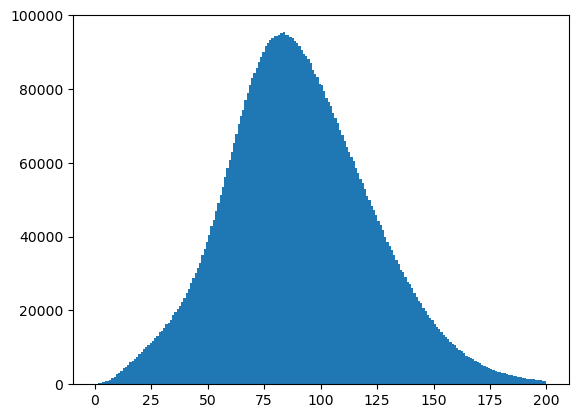

In [141]:
plt.hist(dists[dists < 200], bins=200)

plt.show()

In [145]:
new_shifts_df.to_parquet("shifts_distance_info.parquet", index=False)

$$ $$

$$ $$

# New section

# Distribution images for report

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import wasserstein_distance

In [5]:
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y


def eval_sim_vs_gt_distances_individual(sim_num, max_dist=400, bins=200):
    # load true distances
    gt_shift_info = pd.read_parquet('shifts_distance_info.parquet')
    gt_distances = gt_shift_info['total_dist'].to_numpy()

    # load distances from a gt simulation
    sim_distances = np.load(f"gt_test_v4/test_{sim_num}/total_distances_array.npy")

    # cut to reasonable max dist
    gt = gt_distances[gt_distances < max_dist].copy()
    sim = sim_distances[sim_distances < max_dist].copy()


    plt.hist(gt,  bins=bins, density=True, alpha=0.35, label="Ground truth")
    plt.hist(sim, bins=bins, density=True, alpha=0.35, label="Simulation")
    plt.xlabel("Shift total distance")
    plt.ylabel("Density")
    plt.legend(loc='upper right')

    plt.savefig("gt_vs_sim_hist.jpg", dpi=300, bbox_inches="tight")

    plt.show()


    # create ecdf comparison plot
    
    xg, yg = ecdf(gt)
    xs, ys = ecdf(sim)
    plt.step(xg, yg, where="post", label="Ground truth")
    plt.step(xs, ys, where="post", label="Simulation")
    plt.xlabel("Shift total distance")
    plt.ylabel("ECDF")
    plt.legend(loc="upper left")

    plt.savefig("gt_vs_sim_ecdf.jpg", dpi=300, bbox_inches="tight")

    plt.show()
    
    
    
    # create QQ plot
    
    qgrid = np.linspace(0.01, 0.99, 99)    
    
    plt.plot(np.quantile(gt, qgrid), np.quantile(sim, qgrid), marker=".", linestyle="none")
    m = max(gt.max(), sim.max())
    plt.plot([0, m], [0, m])
    plt.xlabel("Ground truth quantiles")
    plt.ylabel("Simulation quantiles")

    plt.savefig("gt_vs_sim_qq_plot.jpg", dpi=300, bbox_inches="tight")
    
    plt.show()

    # print stats
    # --- KS test/statistic ---
    ks = stats.ks_2samp(gt, sim, alternative="two-sided", mode="auto")
    print("KS statistic:", ks.statistic, "p-value:", ks.pvalue)
    
    # --- Wasserstein distance ---
    wd = wasserstein_distance(gt, sim)
    print("Wasserstein distance:", wd)
    
    # --- Quantile comparison ---
    qs = [0.4, 0.5, 0.75, 0.9, 0.95, 0.99]
    gt_q = np.quantile(gt, qs)
    sim_q = np.quantile(sim, qs)
    rel_err = (sim_q - gt_q) / gt_q
    for q, g, s, e in zip(qs, gt_q, sim_q, rel_err):
        print(f"Q{int(q*100):02d}: gt={g:.2f}, sim={s:.2f}, rel_err={e:+.1%}")

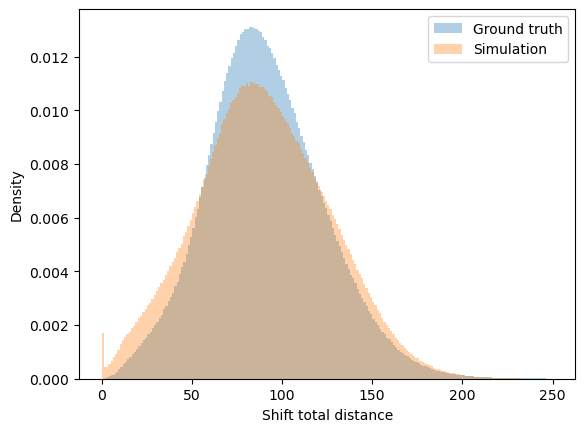

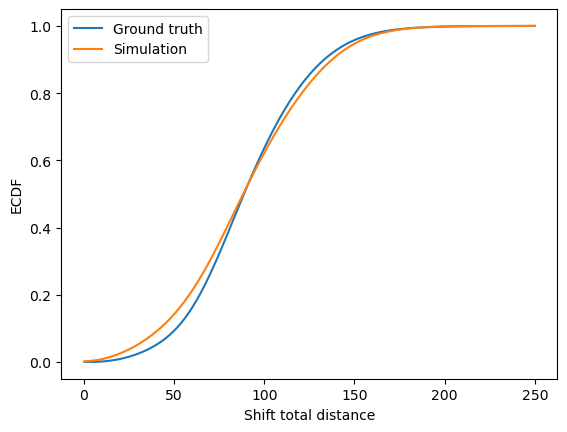

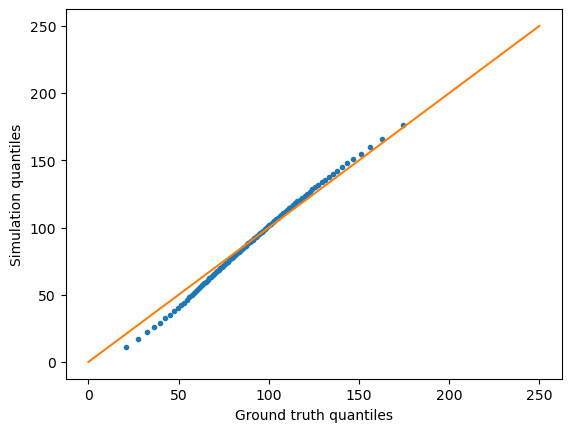

KS statistic: 0.051444261290957444 p-value: 0.0
Wasserstein distance: 3.8630473563528023
Q40: gt=81.05, sim=79.19, rel_err=-2.3%
Q50: gt=88.72, sim=88.30, rel_err=-0.5%
Q75: gt=111.17, sim=114.19, rel_err=+2.7%
Q90: gt=133.22, sim=137.61, rel_err=+3.3%
Q95: gt=146.88, sim=151.03, rel_err=+2.8%
Q99: gt=174.28, sim=176.34, rel_err=+1.2%


In [6]:
eval_sim_vs_gt_distances_individual(sim_num=0, max_dist=250)